# Discrete Laplacian
--------------------

We solve the discrete Dirichlet problem 
$$ \mathcal{L} F(x) = 0, \quad x \in A $$ subjet to the (discrete) boundary condition
$$ F(x) = G(x), \quad x \in \partial A, $$
where $A \subset Z^d$ is finite, $G$ is given and ${\mathcal{L}}$ is the discrete laplacian given by
$$ \mathcal{L} F(x)= \frac{1}{2d}\sum_{y\in A, |x-y|=1}(F(y)-F(x)).$$ Equivalently
$$ \mathcal{L} = Q - I$$ where
$$ QF(x) =  \frac{1}{2d}\sum_{y\in A, |x-y|=1}F(y).$$



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipython_animated_array import AnimateArray
import vizarray 
# pip install ipython-animated-array

## The set $\bar{A}:$

Asume that
$$ \bar{A} = \{ x_0, \cdots, x_{N-1}\}$$

In [2]:
tol = 10**(-4)
d = 2.0
from itertools import product
bl1 =  list(product([0, 1,2,3, 4, 5],repeat = 2))
bl2 = list(product([0, 1,2,3],[6,7,8]))
block =bl1+bl2
block.remove((0,8))
block.remove((3,8))
block.remove((0,0))
block.remove((5,0))
block.remove((5,5))
clA = np.array(block)
npoints = len(clA)

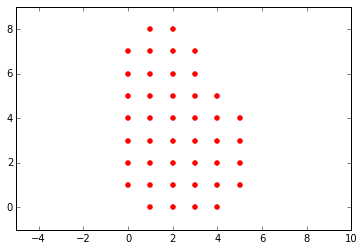

In [3]:
x_list = [x for [x, y] in clA]
y_list = [y for [x, y] in clA]
plt.axis('equal')
plt.scatter(x_list, y_list, marker='o', color='r')

## Construction of Q

In [4]:
diff =clA.reshape(npoints,1,2) - clA
diff = np.sqrt((diff**2)).sum(2)
#ii = range(npoints)
#D[ii, ii] = np.inf 
diff[1,:]

array([ 1.,  0.,  1.,  2.,  3.,  3.,  2.,  1.,  2.,  3.,  4.,  4.,  3.,
        2.,  3.,  4.,  5.,  5.,  4.,  3.,  4.,  5.,  6.,  6.,  5.,  4.,
        5.,  6.,  7.,  6.,  5.,  6.,  7.,  4.,  5.,  5.,  6.,  7.,  6.,
        7.,  8.,  7.,  8.])

In [5]:
def Qbuild(r):
    if np.abs(r-1)< tol: return 1/(2*d)
    else: return 0.0 
    
Qbuild = np.vectorize(Qbuild, otypes=[np.float])

Q = Qbuild(diff)

sum_colQ = Q.sum(axis=1)
#sum_col

Notice that $Q$ is not a Markov matrix. Below is the heat map of $Q$

<matplotlib.colorbar.Colorbar instance at 0x7f9afbb3ce60>

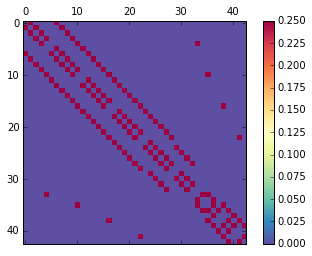

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax= ax.matshow(Q,  cmap=plt.cm.Spectral_r)
fig.colorbar(cax)

As a byproduct of constructing $Q$ we could identifiy the boundary points of $A.$  
   
   $y_i\in \bar{A}$ is a boundary point iff 
   $$ \sum_jQ(i,j)<1$$

In [7]:
mask = sum_colQ < 1
cmask = abs(sum_colQ - 1) <  tol
b_idx = np.where(mask)
a_inx = np.where(cmask)
bndA = clA[b_idx]
A = clA[a_inx]

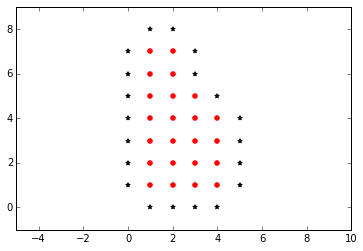

In [8]:
xb_list = [x for [x, y] in bndA]
yb_list = [y for [x, y] in bndA]
xa_list = [x for [x, y] in A]
ya_list = [y for [x, y] in A]
plt.axis('equal')
plt.scatter(xa_list, ya_list, marker='o', color='r')
plt.scatter(xb_list, yb_list, marker='*', color='k')

# Construction of Laplace operator

In [9]:
Q[mask] = 0
Id = np.identity(npoints)
Lpl = Q - Id
Lpl[b_idx,b_idx]=1.0

<matplotlib.colorbar.Colorbar instance at 0x7f9afb8f40e0>

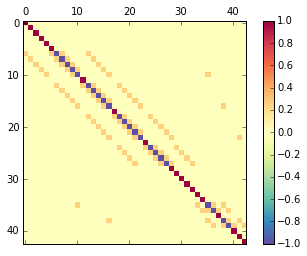

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax= ax.matshow(Lpl,  cmap=plt.cm.Spectral_r)
fig.colorbar(cax)

# Dirichlet Problem

In [11]:
def Gbuild(x):
    a, b = x[0], x[1]
    return a*b

Gb = np.array([Gbuild(x) for x in bndA])

G = np.zeros(npoints)
G[mask] = Gb
np.linalg.solve(Lpl,G)

array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,   5.,
         0.,   2.,   4.,   6.,   8.,  10.,   0.,   3.,   6.,   9.,  12.,
        15.,   0.,   4.,   8.,  12.,  16.,  20.,   5.,  10.,  15.,  20.,
         0.,   0.,   6.,   7.,   8.,  12.,  14.,  16.,  18.,  21.])

# Simulation of a random  walks starting in $\bar{A}$

In [31]:
check_bp = dict()
for y in range(npoints):
    if y in b_idx[0]: check_bp[y]= 1
    else: check_bp[y]= 0

In [32]:
Q[b_idx,b_idx]=1.0

In [33]:
def next_step(x):
    pdf = Q[x,:]
    return np.random.choice(npoints,1, p=pdf)[0]

In [129]:
def poisson_kernel(x):
    pk = dict()
    for i in range(10*npoints):
        chk, z = 0, x
        while chk < 1:
            z = next_step(z)
            chk = check_bp[z]
            if chk == 1: pk[z]= pk.get(z,0) +1
    return pk

In [130]:
def stochastic_solution(x):
    pk = poisson_kernel(x)
    key, val  = G[np.array(pk.keys())], np.array(pk.values())
    s = val.sum()
    return (key*val).sum()/s

In [131]:
%time stochastic_solution(21)

CPU times: user 93.6 ms, sys: 4.03 ms, total: 97.6 ms
Wall time: 93.9 ms


11.495348837209303

In [132]:
% time np.linalg.solve(Lpl,G)[21]

CPU times: user 145 µs, sys: 1e+03 ns, total: 146 µs
Wall time: 143 µs


12.0

In [136]:
def orbit(x):
    orb = []
    chk, z, pdf = 0, x, Q[x,:]
    while chk < 1:
            z = next_step(z)
            chk = check_bp[z]
            orb.append(z)
    return orb

In [143]:
clA[orbit(21)].T

array([[3, 3, 3, 4, 5],
       [3, 2, 1, 1, 1]])

In [144]:
wlk =clA[orbit(21)].T
wlk

array([[2, 2, 2, 2, 1, 0],
       [4, 5, 6, 5, 5, 5]])

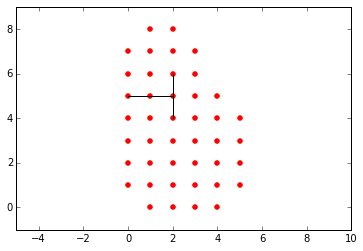

In [145]:
x_list = [x for [x, y] in block]
y_list = [y for [x, y] in block]
plt.axis('equal')
plt.scatter(x_list, y_list, marker='o', color='r')
plt.plot(wlk[0], wlk[1], color='k')

# Heat map of the $Q$ matrix

In [146]:
def potence(n, M):
    if n ==1: return M
    else: return np.dot(M, potence(n-1,M))

<matplotlib.colorbar.Colorbar instance at 0x7f9afb27e710>

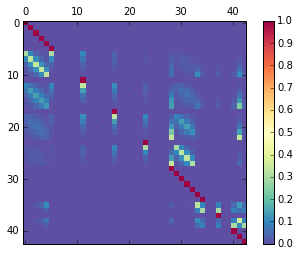

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax= ax.matshow(potence(18,Q),  cmap=plt.cm.Spectral_r)
fig.colorbar(cax)